# Определение возраста покупателей

**План работы**
1. Провести исследовательский анализ набора фотографий.
2. Подготовить данные к обучению.
3. Обучить нейронную сеть по предсказанию возраста и рассчитайте её качество.
4. Сделать выводы об эффективности неройнной сети.

## Исследовательский анализ данных

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.shape

(7591, 2)

Выборка для обучения нейронной сети, предсказывающей возраст клиентов, небольшая, что может привести к недообучению и, как следсвие, к небольшой эффективности модели. Выборку можно увеличить применяя аугментации.

In [4]:
print(labels.describe())

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


array([[<AxesSubplot:title={'center':'real_age'}>]], dtype=object)

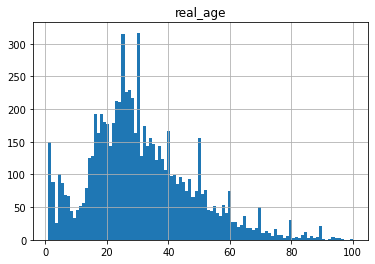

In [5]:
labels.hist(bins=100)

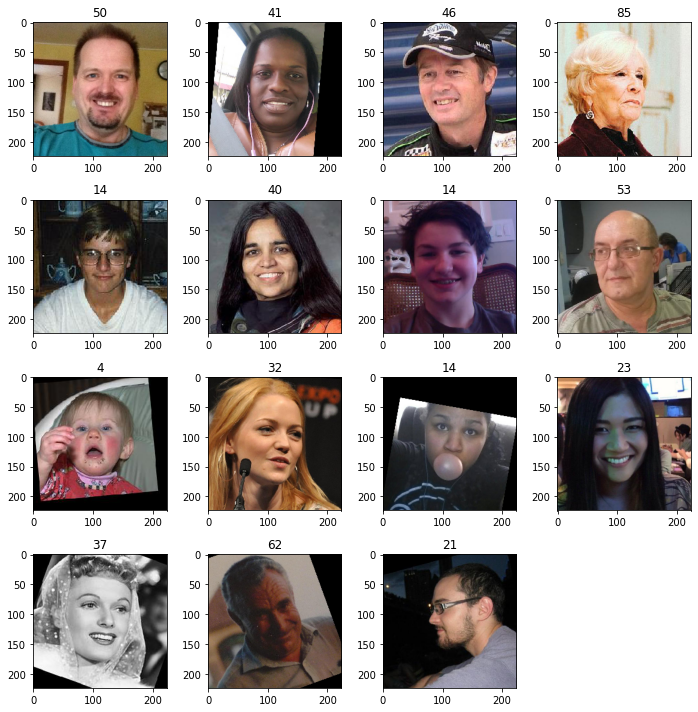

In [6]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.tight_layout()

**Выводы**

Всего имеется 7591 фотографий.

Минимальный возраст в выборке - 1 год, максимальный - 100 лет.

Чаще всего встречаются люди возраст которых находится в диапозоне от 18 до 35.

Могут возникнуть проблемы у модели с предсказанием возраста людей, ведь имеются некачественные фото(низкого качества или фото в профиль) и фото с помехами (жевачка, например)

В датасете имеются чёрно-белые картинки. Размер у фотографий отличаются. Однородность фотографий по цветовой гамме и размерности отсутствует.

Не у всех фотографий ориентация вертикальная, поэтому для тренировки нейросети фотографии нужно будет поворачивать. Данное действие повысит эффективность работы нейросети.


## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

**Код модели**

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, vertical_flip=True, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

**Вывод модели**

```

Epoch 1/10
2022-08-23 18:32:12.347277: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-23 18:32:12.665008: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 53s - loss: 203.9125 - mae: 10.3332 - val_loss: 886.1368 - val_mae: 24.9428
Epoch 2/10
356/356 - 46s - loss: 82.6647 - mae: 6.9641 - val_loss: 129.6565 - val_mae: 8.8333
Epoch 3/10
356/356 - 57s - loss: 58.3639 - mae: 5.8123 - val_loss: 118.5560 - val_mae: 8.3508
Epoch 4/10
356/356 - 56s - loss: 40.7079 - mae: 4.9340 - val_loss: 88.8184 - val_mae: 6.8910
Epoch 5/10
356/356 - 51s - loss: 32.3291 - mae: 4.3309 - val_loss: 70.1249 - val_mae: 6.2975
Epoch 6/10
356/356 - 51s - loss: 24.2573 - mae: 3.7851 - val_loss: 77.7327 - val_mae: 6.5416
Epoch 7/10
356/356 - 57s - loss: 19.8457 - mae: 3.4062 - val_loss: 74.6155 - val_mae: 6.3169
Epoch 8/10
356/356 - 55s - loss: 17.1736 - mae: 3.1525 - val_loss: 75.9439 - val_mae: 6.4325
Epoch 9/10
356/356 - 49s - loss: 14.5063 - mae: 2.9225 - val_loss: 69.5325 - val_mae: 6.2056
Epoch 10/10
356/356 - 59s - loss: 13.5312 - mae: 2.8130 - val_loss: 64.2033 - val_mae: 6.0392
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 12s - loss: 64.2033 - mae: 6.0392
Test MAE: 6.0392
# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

```

## Анализ обученной модели

**Вывод**

Нейронная сеть, обученная по модели ResNet50 с добавлением поворотов изображений для тренировки данных, показывает хорошие результаты (MAE=6), что позволяет сделать вывод, что модель может предсказывать возраст покупателей с высокой точностью. Погрешность модели составляет 6 лет, что приемлемо в данной ситуации, ведь человек может выглядеть на один возраст, а по факту иметь другой возраст.

Данная нейронная сеть эффективна и её можно применять на практике в компании. Данную нейронную сеть не стоит использовать как абсолют в определении возраста покупателя для продажи алкоголя. В данном случае погрешность будет значимой.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы